In [1]:
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
dataset_key = "ad43e954-dd79-4986-ae34-9ccdbd8bf568" # Geographically tagged INSDC sequences dataset

In [3]:
def get_all_downloads_involved_citations(dataset_key,
                                         paging_step = 200,
                                         api_call="https://www.gbif.org/api/resource/search"):
    '''
    Uses the API to get a list of all the download keys that were cited
    '''
    list_download_keys = []
    endOfRecords = False
    offset = 0
    while not endOfRecords:
        params = {
            "contentType": "literature",
            "gbifDatasetKey": dataset_key,
            "offset": offset,
            "limit": paging_step
        }
        response = requests.get(api_call, params)
        if response.ok:
            citation_list = response.json()
            for citation in citation_list["results"]:
                list_download_keys += citation["gbifDownloadKey"]
            endOfRecords = citation_list["endOfRecords"]
            offset += paging_step
        else:
            print("issue", params)
            endOfRecords = True
    return list_download_keys

In [4]:
def get_dataset_download_numbers(dataset_key,
                                 download_key,
                                 paging_step = 200,
                                 api_call="https://api.gbif.org/v1/occurrence/download/"):
    '''
    Uses the API to get number of records from a given dataset in a download, total records in that download
    and total number of dataset
    '''
    downloads = {
        "downloadKey": download_key,
        "numberRecords": 0,
        "totalRecords": 0,
        "numberDatasets": 0
    }
    endOfRecords = False
    offset = 0
    
    while not endOfRecords:
        params = {
            "offset": offset,
            "limit": paging_step
        }
        response = requests.get(api_call+download_key+"/datasets", params)
        if response.ok:
            downloaded_datasets = response.json()
            endOfRecords = downloaded_datasets["endOfRecords"]
            downloads["numberDatasets"] = downloaded_datasets["count"]
            
            for dataset in downloaded_datasets["results"]:
                downloads["totalRecords"] += dataset["numberRecords"]
                if dataset["datasetKey"] == dataset_key:
                    downloads["numberRecords"] = dataset["numberRecords"]
                    
            offset += paging_step
        else:
            print("issue", params)
            endOfRecords = True
    return downloads

In [5]:
cited_download = get_all_downloads_involved_citations(dataset_key)

In [8]:
cited_download_stats = []
for download in cited_download:
    cited_download_stats.append(get_dataset_download_numbers(dataset_key,download, 500))

In [9]:
pd_cited_download_stats = pd.DataFrame(cited_download_stats).set_index("downloadKey")

In [47]:
pd_cited_download_stats_no_zero = pd_cited_download_stats[pd_cited_download_stats["numberRecords"]>0]

In [51]:
pd_cited_download_stats_no_zero.to_csv("nb_records_contributing_to_GBIF_citations_from_INSDC_dataset.csv", sep="\t")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8113954710>]],
      dtype=object)

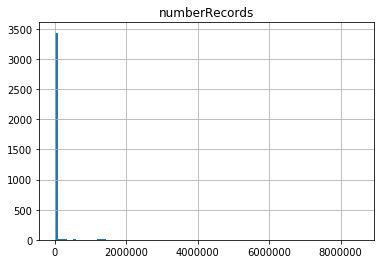

In [48]:
pd_cited_download_stats_no_zero.hist(column=["numberRecords"],bins=100)

(0, 10000)

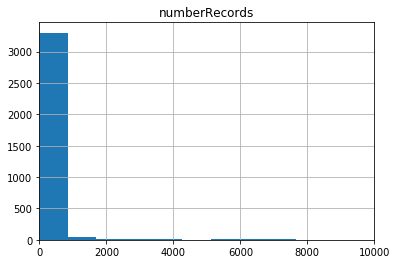

In [49]:
pd_cited_download_stats_no_zero.hist(column=["numberRecords"],bins=10000)
plt.xlim(0,10000)

In [53]:
pd_cited_download_stats_no_zero.median()

numberRecords         7.0
totalRecords      20867.5
numberDatasets      113.0
dtype: float64

In [54]:
pd_cited_download_stats_no_zero.mean()

numberRecords     3.236751e+04
totalRecords      5.677073e+06
numberDatasets    2.918200e+02
dtype: float64